In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

2.3.0
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

<ipython-input-2-2c44e8e6a4b2>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
<ipython-input-2-2c44e8e6a4b2>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(30162, 41)
(15060, 41)


In [4]:
tf.keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[41,]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [5]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
keras_class.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

Epoch 1/30
849/849 [==============================] - 1s 1ms/step - loss: 2.0490 - accuracy: 0.0319 - val_loss: 1.6484 - val_accuracy: 0.0040
Epoch 2/30
849/849 [==============================] - 1s 648us/step - loss: 1.7774 - accuracy: 0.0323 - val_loss: 1.7254 - val_accuracy: 0.0912
Epoch 3/30
849/849 [==============================] - 1s 679us/step - loss: 1.5201 - accuracy: 0.0357 - val_loss: 2.5701 - val_accuracy: 0.0000e+00
Epoch 4/30
849/849 [==============================] - 1s 761us/step - loss: 2.3740 - accuracy: 0.0021 - val_loss: 2.2190 - val_accuracy: 0.0192
Epoch 5/30
849/849 [==============================] - 1s 736us/step - loss: 2.2911 - accuracy: 0.0017 - val_loss: 2.2835 - val_accuracy: 9.9437e-04
Epoch 6/30
849/849 [==============================] - 1s 768us/step - loss: 2.2764 - accuracy: 0.0048 - val_loss: 2.3124 - val_accuracy: 0.0046
Epoch 7/30
849/849 [==============================] - 1s 711us/step - loss: 2.7188 - accuracy: 0.0092 - val_loss: 2.5447 - val_acc

# Zad

Wykonajmy RandomizedSearchCV

In [16]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1],
#     "n_neurons": np.arange(1, 10)
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

C:\conda\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/30
1032/1032 [==============================] - 1s 1ms/step - loss: -52.8867 - accuracy: 0.1006 - val_loss: -53.2353 - val_accuracy: 0.0905
Epoch 2/30
1032/1032 [==============================] - 1s 1ms/step - loss: -53.3141 - accuracy: 0.1004 - val_loss: -53.2537 - val_accuracy: 0.0905
Epoch 3/30
1032/1032 [==============================] - 1s 879us/step - loss: -53.3242 - accuracy: 0.1004 - val_loss: -53.2666 - val_accuracy: 0.0905
Epoch 4/30
1032/1032 [==============================] - 1s 942us/step - loss: -53.3274 - accuracy: 0.1004 - val_loss: -53.2704 - val_accuracy: 0.0905
Epoch 5/30
1032/1032 [==============================] - 1s 909us/step - loss: -53.3278 - accuracy: 0.1004 - val_loss: -53.2736 - val_accuracy: 0.0905
Epoch 6/30
1032/1032 [==============================] - 1s 974us/step - loss: -53.3283 - accuracy: 0.1004 - val_loss: -53.2754 - val_accuracy: 0.0905
Epoch 7/30
1032/1032 [=======================

Epoch 24/30
1032/1032 [==============================] - 1s 925us/step - loss: -53.2044 - accuracy: 0.0769 - val_loss: -53.2894 - val_accuracy: 0.0804
Epoch 25/30
1032/1032 [==============================] - 1s 785us/step - loss: -53.2044 - accuracy: 0.0769 - val_loss: -53.2895 - val_accuracy: 0.0804
Epoch 26/30
1032/1032 [==============================] - 1s 669us/step - loss: -53.2044 - accuracy: 0.0769 - val_loss: -53.2910 - val_accuracy: 0.0807
Epoch 27/30
1032/1032 [==============================] - 1s 757us/step - loss: -53.2043 - accuracy: 0.0769 - val_loss: -53.2922 - val_accuracy: 0.0807
Epoch 28/30
1032/1032 [==============================] - 1s 722us/step - loss: -53.2045 - accuracy: 0.0769 - val_loss: -53.2922 - val_accuracy: 0.0807
Epoch 29/30
1032/1032 [==============================] - 1s 648us/step - loss: -53.2044 - accuracy: 0.0769 - val_loss: -53.2922 - val_accuracy: 0.0807
Epoch 30/30
573/573 [==============================] - 0s 539us/step - loss: -53.6854 - accura

573/573 [==============================] - 0s 678us/step - loss: -28.8663 - accuracy: 0.1017
[CV] END .........................................n_hidden=1; total time=  17.6s
Epoch 1/30
1032/1032 [==============================] - 1s 1ms/step - loss: -51.4450 - accuracy: 0.1032 - val_loss: -53.2852 - val_accuracy: 0.0954
Epoch 2/30
1032/1032 [==============================] - 1s 1ms/step - loss: -53.2024 - accuracy: 0.1021 - val_loss: -53.2895 - val_accuracy: 0.0954
Epoch 3/30
1032/1032 [==============================] - 1s 961us/step - loss: -53.2039 - accuracy: 0.1021 - val_loss: -53.2954 - val_accuracy: 0.0954
Epoch 4/30
1032/1032 [==============================] - 1s 958us/step - loss: -53.2044 - accuracy: 0.1021 - val_loss: -53.2954 - val_accuracy: 0.0954
Epoch 5/30
1032/1032 [==============================] - 1s 908us/step - loss: -53.2045 - accuracy: 0.1021 - val_loss: -53.2954 - val_accuracy: 0.0954
Epoch 6/30
1032/1032 [==============================] - 1s 1ms/step - loss: -53.

Epoch 12/30
1547/1547 [==============================] - 2s 985us/step - loss: -53.3975 - accuracy: 0.0998 - val_loss: -53.1450 - val_accuracy: 0.1015
Epoch 00012: early stopping


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002092D819F10>,
                   param_distributions={'n_hidden': [0, 1]}, verbose=2)

In [19]:
rnd_search_cv.best_params_

{'n_neurons': 86, 'n_hidden': 0}

# Zad

Wykonaj RandomizedSearchCV na danych FashionMINT


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [11]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Coat'

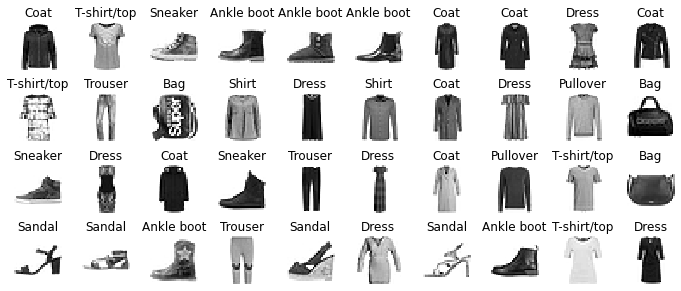

In [13]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [14]:
tf.keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=(28,28,)):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
keras_class.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

Epoch 1/30
1547/1547 [==============================] - 2s 1ms/step - loss: -53.2660 - accuracy: 0.0993 - val_loss: -53.1403 - val_accuracy: 0.0984
Epoch 2/30
1547/1547 [==============================] - 1s 921us/step - loss: -53.3961 - accuracy: 0.1001 - val_loss: -53.1421 - val_accuracy: 0.0984
Epoch 3/30
1547/1547 [==============================] - 2s 988us/step - loss: -53.3969 - accuracy: 0.1001 - val_loss: -53.1427 - val_accuracy: 0.0984
Epoch 4/30
1547/1547 [==============================] - ETA: 0s - loss: -53.4019 - accuracy: 0.10 - 2s 1ms/step - loss: -53.3971 - accuracy: 0.1001 - val_loss: -53.1438 - val_accuracy: 0.0984
Epoch 5/30
1547/1547 [==============================] - 2s 1ms/step - loss: -53.3972 - accuracy: 0.1001 - val_loss: -53.1438 - val_accuracy: 0.0984
Epoch 6/30
1547/1547 [==============================] - 2s 985us/step - loss: -53.3975 - accuracy: 0.1001 - val_loss: -53.1440 - val_accuracy: 0.0984
Epoch 7/30
1547/1547 [==============================] - 2s 1ms

In [17]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.3823 - accuracy: 0.1011 - val_loss: -16.5052 - val_accuracy: 0.1023
Epoch 2/30
1032/1032 [==============================] - 1s 984us/step - loss: -16.5211 - accuracy: 0.1010 - val_loss: -16.5053 - val_accuracy: 0.1023
Epoch 3/30
1032/1032 [==============================] - 1s 912us/step - loss: -16.5211 - accuracy: 0.1010 - val_loss: -16.5064 - val_accuracy: 0.1023
Epoch 4/30
1032/1032 [==============================] - 1s 965us/step - loss: -16.5211 - accuracy: 0.1010 - val_loss: -16.5064 - val_accuracy: 0.1023
Epoch 5/30
1032/1032 [==============================] - 1s 961us/step - loss: -16.5211 - accuracy: 0.1010 - val_loss: -16.5064 - val_accuracy: 0.1023
Epoch 6/30
1032/1032 [==============================] - 1s 983us/step - loss: -16.5213 - accuracy: 0.1010 - val_loss: -16.5064 - val_accuracy: 0.1023
Epoch 7/30
1032/1032 [===================

1032/1032 [==============================] - 1s 1ms/step - loss: -16.5216 - accuracy: 0.0989 - val_loss: -16.5002 - val_accuracy: 0.0987
Epoch 15/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0986 - val_loss: -16.5002 - val_accuracy: 0.0987
Epoch 16/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0987 - val_loss: -16.5001 - val_accuracy: 0.0990
Epoch 17/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0986 - val_loss: -16.5001 - val_accuracy: 0.0993
Epoch 18/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0987 - val_loss: -16.4989 - val_accuracy: 0.0990
Epoch 19/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0987 - val_loss: -16.4987 - val_accuracy: 0.0990
Epoch 00019: early stopping
573/573 [==============================] - 0s 753us/step - loss: -16.5696 - accuracy: 0.09

Epoch 00012: early stopping
573/573 [==============================] - 1s 1ms/step - loss: -28.8655 - accuracy: 0.0970
[CV] END ...........................n_hidden=3, n_neurons=97; total time=  22.4s
Epoch 1/30
1032/1032 [==============================] - 2s 2ms/step - loss: -28.7827 - accuracy: 0.0999 - val_loss: -28.7694 - val_accuracy: 0.1036
Epoch 2/30
1032/1032 [==============================] - 1s 1ms/step - loss: -28.7157 - accuracy: 0.1000 - val_loss: -28.7694 - val_accuracy: 0.1036
Epoch 3/30
1032/1032 [==============================] - 1s 1ms/step - loss: -28.7157 - accuracy: 0.1000 - val_loss: -28.7694 - val_accuracy: 0.1036
Epoch 4/30
1032/1032 [==============================] - 1s 1ms/step - loss: -28.7157 - accuracy: 0.1000 - val_loss: -28.7694 - val_accuracy: 0.1036
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: -28.7157 - accuracy: 0.1000 - val_loss: -28.7694 - val_accuracy: 0.1036
Epoch 6/30
1032/1032 [==============================] - 2s 2

Epoch 28/30
1032/1032 [==============================] - 1s 800us/step - loss: -53.3328 - accuracy: 0.0994 - val_loss: -53.2832 - val_accuracy: 0.0952
Epoch 29/30
1032/1032 [==============================] - 1s 811us/step - loss: -53.3329 - accuracy: 0.0994 - val_loss: -53.2824 - val_accuracy: 0.0952
Epoch 30/30
573/573 [==============================] - 0s 540us/step - loss: -53.4545 - accuracy: 0.1048
[CV] END ...........................n_hidden=0, n_neurons=86; total time=  29.3s
Epoch 1/30
1032/1032 [==============================] - 1s 1ms/step - loss: -52.8274 - accuracy: 0.1090 - val_loss: -53.2271 - val_accuracy: 0.1036
Epoch 2/30
1032/1032 [==============================] - 1s 983us/step - loss: -53.1845 - accuracy: 0.0994 - val_loss: -53.2540 - val_accuracy: 0.1036
Epoch 3/30
1032/1032 [==============================] - 1s 997us/step - loss: -53.1943 - accuracy: 0.0991 - val_loss: -53.2634 - val_accuracy: 0.1034
Epoch 4/30
1032/1032 [==============================] - 1s 1ms/s

Epoch 20/30
1032/1032 [==============================] - 1s 876us/step - loss: -53.5879 - accuracy: 0.0758 - val_loss: -53.4188 - val_accuracy: 0.0676
Epoch 21/30
1032/1032 [==============================] - 1s 846us/step - loss: -53.5880 - accuracy: 0.0758 - val_loss: -53.4188 - val_accuracy: 0.0676
Epoch 22/30
1032/1032 [==============================] - 1s 915us/step - loss: -53.5879 - accuracy: 0.0758 - val_loss: -53.4188 - val_accuracy: 0.0676
Epoch 23/30
1032/1032 [==============================] - 1s 834us/step - loss: -53.5880 - accuracy: 0.0758 - val_loss: -53.4185 - val_accuracy: 0.0676
Epoch 00023: early stopping
573/573 [==============================] - 0s 637us/step - loss: -52.9710 - accuracy: 0.0762
[CV] END ...........................n_hidden=0, n_neurons=86; total time=  22.3s
Epoch 1/30
1032/1032 [==============================] - 1s 1ms/step - loss: -52.8353 - accuracy: 0.0989 - val_loss: -53.2846 - val_accuracy: 0.0954
Epoch 2/30
1032/1032 [========================

Epoch 7/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.1002 - val_loss: -41.0324 - val_accuracy: 0.1072
Epoch 8/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.1002 - val_loss: -41.0324 - val_accuracy: 0.1072
Epoch 9/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.1002 - val_loss: -41.0324 - val_accuracy: 0.1072
Epoch 10/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0627 - accuracy: 0.1002 - val_loss: -41.0324 - val_accuracy: 0.1072
Epoch 11/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0627 - accuracy: 0.1002 - val_loss: -41.0324 - val_accuracy: 0.1072
Epoch 00011: early stopping
573/573 [==============================] - 0s 715us/step - loss: -41.1623 - accuracy: 0.0989
[CV] END ...........................n_hidden=2, n_neurons=71; total time=  16.0s
Epoch 1/30
1032/1032 [==============================] - 

1032/1032 [==============================] - 1s 1ms/step - loss: -41.0626 - accuracy: 0.0999 - val_loss: -41.0310 - val_accuracy: 0.1017
Epoch 14/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0626 - accuracy: 0.0999 - val_loss: -41.0310 - val_accuracy: 0.1017
Epoch 15/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.0999 - val_loss: -41.0310 - val_accuracy: 0.1017
Epoch 16/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0626 - accuracy: 0.0999 - val_loss: -41.0310 - val_accuracy: 0.1017
Epoch 17/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.0999 - val_loss: -41.0310 - val_accuracy: 0.1017
Epoch 18/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0625 - accuracy: 0.0999 - val_loss: -41.0311 - val_accuracy: 0.1017
Epoch 19/30
1032/1032 [==============================] - 1s 1ms/step - loss: -41.0626 - accuracy: 0.0999 - val_loss: -

1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 8/30
1032/1032 [==============================] - 2s 2ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 9/30
1032/1032 [==============================] - 2s 2ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 10/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 11/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 12/30
1032/1032 [==============================] - 1s 1ms/step - loss: -16.5217 - accuracy: 0.0996 - val_loss: -16.5064 - val_accuracy: 0.0995
Epoch 00012: early stopping
573/573 [==============================] - 0s 615us/step - loss: -16.5710 - accuracy: 0.0978

1032/1032 [==============================] - 1s 911us/step - loss: 20.2911 - accuracy: 0.0989 - val_loss: 20.2863 - val_accuracy: 0.1036
Epoch 7/30
1032/1032 [==============================] - 1s 811us/step - loss: 20.2906 - accuracy: 0.0989 - val_loss: 20.2849 - val_accuracy: 0.1036
Epoch 8/30
1032/1032 [==============================] - 1s 919us/step - loss: 20.2902 - accuracy: 0.0989 - val_loss: 20.2860 - val_accuracy: 0.1036
Epoch 9/30
1032/1032 [==============================] - 1s 804us/step - loss: 20.2902 - accuracy: 0.0989 - val_loss: 20.2838 - val_accuracy: 0.1036
Epoch 10/30
1032/1032 [==============================] - 1s 809us/step - loss: 20.2901 - accuracy: 0.0989 - val_loss: 20.2850 - val_accuracy: 0.1036
Epoch 11/30
1032/1032 [==============================] - 1s 1ms/step - loss: 20.2900 - accuracy: 0.0989 - val_loss: 20.2851 - val_accuracy: 0.1036
Epoch 12/30
1032/1032 [==============================] - 1s 892us/step - loss: 20.2900 - accuracy: 0.0989 - val_loss: 20.28

1032/1032 [==============================] - 2s 2ms/step - loss: -41.0640 - accuracy: 0.1086 - val_loss: -41.0324 - val_accuracy: 0.1023
Epoch 12/30
1032/1032 [==============================] - 2s 2ms/step - loss: -41.0642 - accuracy: 0.1065 - val_loss: -41.0309 - val_accuracy: 0.0957
Epoch 00012: early stopping
573/573 [==============================] - 1s 1ms/step - loss: -41.1607 - accuracy: 0.0999
[CV] END ...........................n_hidden=3, n_neurons=99; total time=  22.0s
Epoch 1/30
1032/1032 [==============================] - 2s 2ms/step - loss: -16.3575 - accuracy: 0.1002 - val_loss: -16.4996 - val_accuracy: 0.1001
Epoch 2/30
1032/1032 [==============================] - 2s 2ms/step - loss: -16.4701 - accuracy: 0.1003 - val_loss: -16.4997 - val_accuracy: 0.1001
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: -16.4702 - accuracy: 0.1003 - val_loss: -16.4998 - val_accuracy: 0.1001
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - 

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002092B8CEAC0>, as the constructor either does not set or modifies parameter n_neurons

In [18]:
rnd_search_cv.best_params_

{'n_neurons': 86, 'n_hidden': 0}

###### 